In [21]:
%matplotlib inline

#standard package import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

#our package import
import neuronal

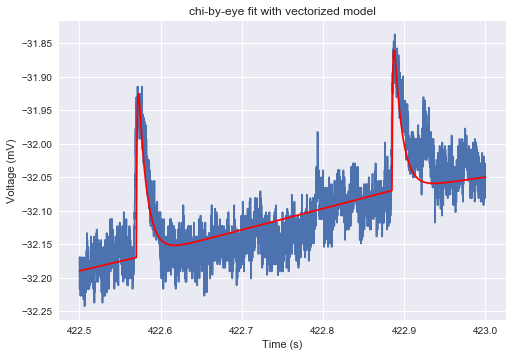

In [22]:
#chi-by-eye fit

two_psp = neuronal.NeuronalData(neuronal.get_example_data_file_path('two_PSP_data.txt'), num_psp=2)

t = two_psp.data['T'].values
v = two_psp.data['V'].values

sigma = 0.026
#Because b is now extended by 2 entries (b_start at the beginning, b_end at the end), 
#and because of our function's structure,
#for vectorization, we need to extend a, t_psp, tau_d, and tau_r with dummy entries accordingly
b = [-32.19, -32.17, -32.07, -32.05]
a = [1, 0.35, 0.3, 1] #1 is a dummy entry
t_psp = [t[0], 422.57, 422.885, t[-1]] #t[0] and t[-1] are dummy entries
tau_d = [1, 0.01, 0.01, 1] #1 is a dummy entry
tau_r = [1, 0.001, 0.001, 1] #1 is a dummy entry

t_resize = np.tile(t, (len(t_psp), 1))
t_psp_resize = np.tile(t_psp, (len(t), 1)).T

t_psp_next = t_psp + np.hstack((np.diff(t_psp), 1e-5))
t_psp_next_resize = np.tile(t_psp_next, (len(t), 1)).T

a_resize = np.tile(a, (len(t), 1)).T
b_resize = np.tile(b, (len(t), 1)).T
tau_d_resize = np.tile(tau_d, (len(t), 1)).T
tau_r_resize = np.tile(tau_r, (len(t), 1)).T

b_next = b + np.hstack((np.diff(b), 1e-5))
b_next_resize = np.tile(b_next, (len(t), 1)).T

#Vectorized model
model = np.sum((t_resize >= t_psp_resize) * 
               (a_resize * (np.exp((t_resize>=t_psp_resize)*-(t_resize-t_psp_resize) / tau_d_resize) - 
                            np.exp((t_resize>=t_psp_resize)*-(t_resize-t_psp_resize) / tau_r_resize)) +
               (t_resize < t_psp_next_resize) * (b_resize + (b_next_resize - b_resize) / (t_psp_next_resize - t_psp_resize) * 
                                                 (t_resize - t_psp_resize))), axis=0)

plt.plot(t, v)
plt.plot(t, model, c='r')
plt.title('chi-by-eye fit with vectorized model')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.show()

Let's time the fully vectorized model

In [23]:
%%time 
model = np.sum((t_resize >= t_psp_resize) * 
               (a_resize * (np.exp((t_resize>=t_psp_resize)*-(t_resize-t_psp_resize) / tau_d_resize) - 
                            np.exp((t_resize>=t_psp_resize)*-(t_resize-t_psp_resize) / tau_r_resize)) +
               (t_resize < t_psp_next_resize) * (b_resize + (b_next_resize - b_resize) / (t_psp_next_resize - t_psp_resize) * 
                                                 (t_resize - t_psp_resize))), axis=0)

CPU times: user 39.9 ms, sys: 864 µs, total: 40.7 ms
Wall time: 15.2 ms


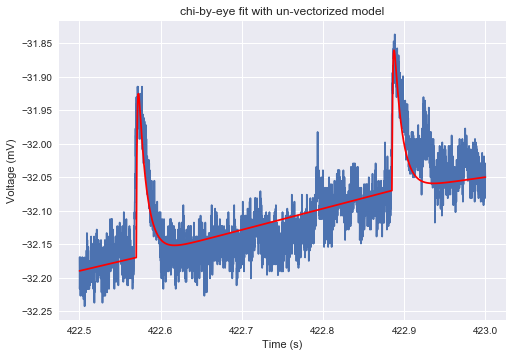

In [24]:
num_psp = two_psp.num_psp
sigma = 0.026
b_start = -32.19
b = [-32.17, -32.07]
b_end = -32.05
a = [0.35, 0.3]
t_psp = [422.57, 422.885]
tau_d = [0.01, 0.01]
tau_r = [0.001, 0.001]

#un-vectorized model
model = (t < t_psp[0]) * (b_start + (b[0] - b_start) / (t_psp[0] - t[0]) * (t - t[0])) +\
        np.sum([
                (t >= t_psp[i]) * (a[i] * (np.exp((t>=t_psp[i])*-(t-t_psp[i]) / tau_d[i]) -\
                                           np.exp((t>=t_psp[i])*-(t-t_psp[i]) / tau_r[i])) +\
                (t < t_psp[i+1]) * (b[i] + (b[i+1] - b[i]) / (t_psp[i+1] - t_psp[i]) * (t - t_psp[i])))
                for i in range(num_psp - 1)], axis=0) +\
        (t >= t_psp[-1]) * (a[-1] * (np.exp((t>=t_psp[-1])*-(t-t_psp[-1]) / tau_d[-1]) -\
                                     np.exp((t>=t_psp[-1])*-(t-t_psp[-1]) / tau_r[-1])) +\
        (b[-1] + (b_end - b[-1]) / (t[-1] - t_psp[-1]) * (t - t_psp[-1])))

plt.plot(t, v)
plt.plot(t, model, c='r')
plt.title('chi-by-eye fit with un-vectorized model')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.show()

Now, let's time the un-vectorized model

In [25]:
%%time 
model = (t < t_psp[0]) * (b_start + (b[0] - b_start) / (t_psp[0] - t[0]) * (t - t[0])) +\
        np.sum([
                (t >= t_psp[i]) * (a[i] * (np.exp((t>=t_psp[i])*-(t-t_psp[i]) / tau_d[i]) -\
                                           np.exp((t>=t_psp[i])*-(t-t_psp[i]) / tau_r[i])) +\
                (t < t_psp[i+1]) * (b[i] + (b[i+1] - b[i]) / (t_psp[i+1] - t_psp[i]) * (t - t_psp[i])))
                for i in range(num_psp - 1)], axis=0) +\
        (t >= t_psp[-1]) * (a[-1] * (np.exp((t>=t_psp[-1])*-(t-t_psp[-1]) / tau_d[-1]) -\
                                     np.exp((t>=t_psp[-1])*-(t-t_psp[-1]) / tau_r[-1])) +\
        (b[-1] + (b_end - b[-1]) / (t[-1] - t_psp[-1]) * (t - t_psp[-1])))

CPU times: user 1.16 ms, sys: 687 µs, total: 1.85 ms
Wall time: 1.2 ms


Interestingly, fully vectorized model takes a lot longer (40.7 ms vs 1.85 ms for unvectorized model).
This must be because although the vectorized model does not need to do the for loop, it now needs to do unnecessary computation caused by the dummy entries; in particular, the starting segment of the unvectorized model does not need any computation involving difference of exponetials, while the vectorized model does such computation just for the sake of matching the dimension of the vector. 

Perhaps, it's posisble to partially vectorize the model... I will need to think about how to do this effectively...